In [23]:
%load_ext autoreload
%autoreload 2
import pyvisa
import time
from PyTLPMX import TLPMX
import numpy as np
import numpy.matlib
import clr
from matplotlib import pyplot as plt
from datetime import datetime
from timeit import default_timer as timer
from scipy.optimize import curve_fit
import csv

clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.DeviceManagerCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.GenericPiezoCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.GenericMotorCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.KCube.PositionAlignerCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.KCube.PiezoCLI.dll")

# Import CLIs
from Thorlabs.MotionControl.DeviceManagerCLI import *
from Thorlabs.MotionControl.GenericMotorCLI import *
from Thorlabs.MotionControl.KCube.PositionAlignerCLI import *
from Thorlabs.MotionControl.KCube.PiezoCLI import *
from Thorlabs.MotionControl.GenericPiezoCLI.Piezo import *
from System import Decimal 
from pyximc import *
from ConnectHardware import *
from Analytics import *
from HardwareControl import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# connect to lock-in amps
rm = pyvisa.ResourceManager()
amp1 = rm.open_resource('GPIB0::8::INSTR')
amp2 = rm.open_resource('GPIB0::9::INSTR')
print(rm.list_resources())

('ASRL3::INSTR', 'ASRL4::INSTR', 'GPIB0::8::INSTR', 'GPIB0::9::INSTR')


In [11]:
# Connect to piezo controller

# enter serial num
piezo = connectKPZ("29252602")
print("Setting Zero Point")
piezo.SetZero()

Connecting to device
Getting device info
KPZ101 Piezo Drive
Setting Zero Point


In [ ]:
numScans = 30
positions = np.array(np.linspace(0, 20, 10))
shifts, TM_paras, TE_paras, t_stamps, errors = estimateShift(piezo, amp1, amp2, numScans, positions)
print(f"Mean shift: {np.mean(shifts)}")

In [24]:
numScans = 20
positions = np.array(np.linspace(0, 20, 5))
shifts, TM_fitParams, TE_fitParams, timestamps = estimateShift_MonoBeam(piezo, amp1, amp2, numScans, positions)
print(f"Mean shift: {np.mean(shifts)}")

Scan 1



Block out TE state then press enter to proceed... 


Moved to 0V

Taking measurement..
Moved to 18.7688833277383V

Taking measurement..
Moved to 37.5331888790551V

Taking measurement..
Moved to 56.2814722128971V

Taking measurement..
Moved to 75V

Taking measurement..
Scan completed



Block out TM state then press enter to proceed... 


Moved to 0V

Taking measurement..
Moved to 18.7757499923704V

Taking measurement..
Moved to 37.5354777672658V

Taking measurement..
Moved to 56.2929166539506V

Taking measurement..
Moved to 75V

Taking measurement..
Scan completed

shift: 0.8955490484533435

Scan 2



Block out TE state then press enter to proceed... 


Moved to 0V

Taking measurement..
Moved to 18.7688833277383V

Taking measurement..
Moved to 37.5308999908444V

Taking measurement..
Moved to 56.2837611011078V

Taking measurement..
Moved to 75V

Taking measurement..
Scan completed



Block out TM state then press enter to proceed... 


Moved to 0V

Taking measurement..
Moved to 18.7688833277383V

Taking measurement..
Moved to 37.5331888790551V

Taking measurement..
Moved to 56.274605548265V

Taking measurement..
Moved to 75V

Taking measurement..
Scan completed

shift: 0.7901389879846263

Mean shift: 0.8428440182189849


Mean: 0.8428440182189849
SD: 0.052705030234358574


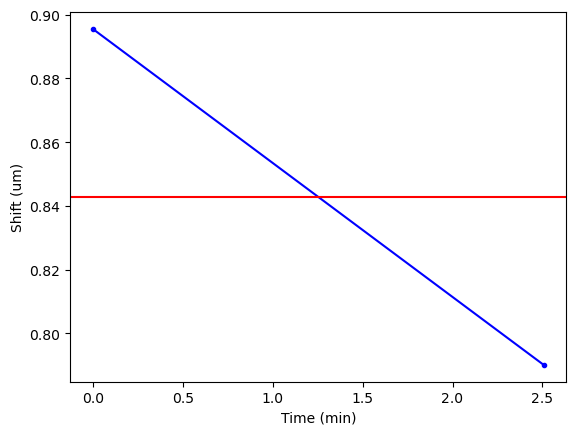

In [29]:
fig2, ax = plt.subplots()
ax.plot(np.divide(timestamps,60),shifts, "b.-")
ax.set_ylabel("Shift (um)")
ax.set_xlabel("Time (min)")
ax.axhline(np.mean(shifts), color="red")
print("Mean: {}".format(np.mean(shifts)))
print("SD: {}".format(np.std(shifts)))
plt.show()

1.1588416626473574


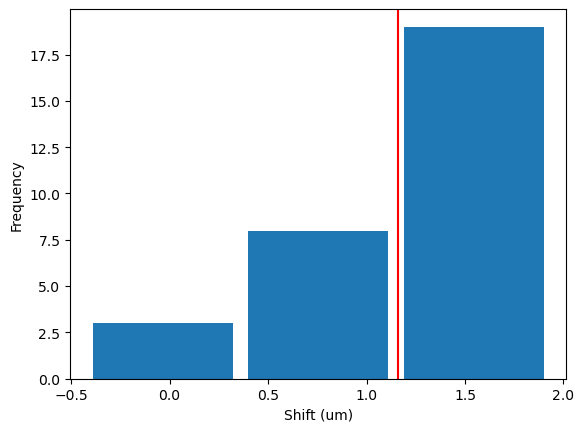

In [52]:
fig3, ax = plt.subplots()
ax.hist(shifts, 3, rwidth=0.9)
ax.set_ylabel("Frequency")
ax.set_xlabel("Shift (um)")
ax.axvline(np.mean(shifts), color="red")
print(np.mean(shifts))
plt.show()

In [53]:
now = datetime.now()
current_time = now.strftime("%H;%M")
file_prefix = "SHIFT DATA NINA_binding_{}_{}".format(numScans, current_time)

figName = file_prefix + ".png"
    
# Save fig to png in figs folder
os.chdir("Figs")
fig3.savefig(figName)
os.chdir("..")
print("Figure Saved")

# Save data to CSV in csv folder
os.chdir("CSVs")
csvFileName = file_prefix + ".csv"
data = [shifts, t_stamps]
header_names = ["Shift (um)", "Time stamps (s)"]
write_array_to_csv(csvFileName, header_names, data)
os.chdir("..")
print("CSV Saved")

Figure Saved
CSV Saved


In [ ]:
# calculate z-score normalisation of data
z_ydiffs = (ydiffs-mean_ydiffs)/std_ydiffs
z_powsums = (powSums-mean_powsums)/std_powsums

In [58]:
# DUAL BEAM SCAN

# Initialise array of positions (in um) to take readings from
positions = np.array(np.linspace(0, 20, 5))

# RUN DUAL BEAM SCAN
TM_signal, TM_err, TE_signal, TE_err = dualBeamScan(amp1, amp2, positions, piezo)

# get fit line and parameters from least square regression
TM_fit, TM_para = lineFit(positions, TM_signal)
TE_fit, TE_para = lineFit(positions, TE_signal)

# Calculate shift from x-intercepts
TM_intercept = -TM_para[1] / TM_para[0]
TE_intercept = -TE_para[1] / TE_para[0]
shift = TM_intercept - TE_intercept

Moved to 0V

Taking measurement..
Moved to 18.7665944395276V

Taking measurement..
Moved to 37.5377666554765V

Taking measurement..
Moved to 56.2860499893185V

Taking measurement..
Moved to 75V

Taking measurement..
Scan completed




Shift: -0.9893073232419525 um
-0.0001309621297167346
-0.0010068724788607707


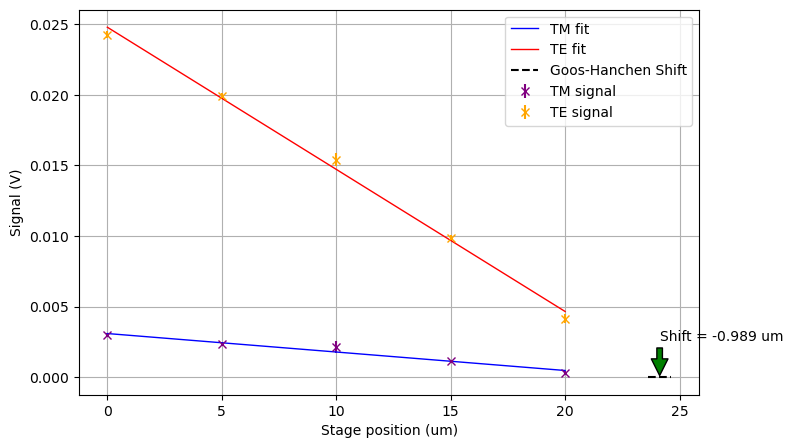

In [59]:
# PLOT RESULTS
fig, ax = plt.subplots(figsize=(8,5))

# calculate error and plot graph
ax.errorbar(positions, TM_signal, TM_err, fmt='x', color="purple")
ax.plot(positions, TM_fit, 'b', label='OLS TM model', linewidth=1)

ax.errorbar(positions, TE_signal, TE_err, fmt='x', color="orange")
ax.plot(positions, TE_fit, 'r', label='OLS TE model', linewidth=1) 

# Labels
ax.set_xlabel('Stage position (um)')
ax.set_ylabel('Signal (V)')
ax.grid()

print("\nShift: {} um".format(shift))

# Label shift
shiftLabel = "Shift = {} um".format(np.round(shift, 3))
xCoord = np.mean([TM_intercept, TE_intercept])
yCoord = ax.get_ylim()[1]*0.1
ax.hlines(0, TM_intercept, TE_intercept, colors='black', linestyles='dashed')
ax.annotate(shiftLabel, xy =(xCoord, 0), 
                xytext =(xCoord, yCoord),  
                arrowprops = dict(facecolor ='green', 
                                  shrink = 0.05),)
# add legend
legend_drawn_flag = True
plt.legend(["TM fit", "TE fit","Goos-Hanchen Shift", "TM signal", "TE signal"], loc=0, frameon=legend_drawn_flag)
print(TM_para[0])
print(TE_para[0])
plt.show()

In [31]:
# save figure
now = datetime.now()
current_time = now.strftime("%H;%M")
file_prefix = "{}-".format("BEAM_SCAN_DATA_WATER") + current_time

figName = file_prefix + ".png"
    
# Save fig to png in figs folder
os.chdir("Figs")
fig.savefig(figName)
os.chdir("..")
print("Saved")

Saved


In [32]:
 # Save data to CSV in csv folder
 os.chdir("CSVs")
 csvFileName = file_prefix + ".csv"
 with open(csvFileName, "w") as txt_file:   
     for i in range(len(positions)):
	        txt_file.write("{}".format(positions[i]) + "," + "{:e}".format(TM_signal[i]) + "," + "{:e}".format(TE_signal[i]) + "\n")
    
 # Return to main folder
 os.chdir("..")
print("Saved")

Saved


In [18]:
# DUAL BEAM SCAN

# Initialise array of positions (in um) to take readings from
positions = np.array(np.linspace(0, 20, 5))

# RUN DUAL BEAM SCAN
input("Block out TE state then press enter to proceed...")
TM_signal, TM_err = monoBeamScan(amp2, positions, piezo)
input("Block out TM state then press enter to proceed...")
TE_signal, TE_err = monoBeamScan(amp1, positions, piezo)

# get fit line and parameters from least square regression
TM_fit, TM_para = lineFit(positions, TM_signal)
TE_fit, TE_para = lineFit(positions, TE_signal)

# Calculate shift from x-intercepts
TM_intercept = -TM_para[1] / TM_para[0]
TE_intercept = -TE_para[1] / TE_para[0]
shift = TM_intercept - TE_intercept

Block out TE state then press enter to proceed... 


Moved to 0V

Taking measurement..
Moved to 18.7757499923704V

Taking measurement..
Moved to 37.5331888790551V

Taking measurement..
Moved to 56.2768944364757V

Taking measurement..
Moved to 75V

Taking measurement..
Scan completed



Block out TM state then press enter to proceed... 


Moved to 0V

Taking measurement..
Moved to 18.7688833277383V

Taking measurement..
Moved to 37.5377666554765V

Taking measurement..
Moved to 56.2768944364757V

Taking measurement..
Moved to 75V

Taking measurement..
Scan completed




Shift: 1.2535509618853702 um
-0.00019193106304545457
-0.0010413374361006539


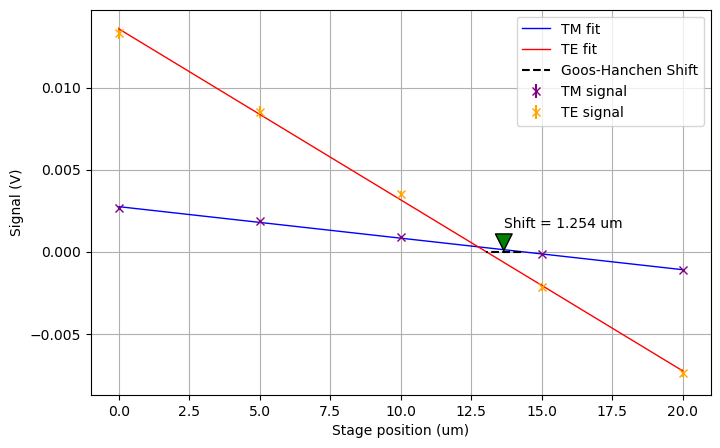

In [19]:
# PLOT RESULTS
fig, ax = plt.subplots(figsize=(8,5))

# calculate error and plot graph
ax.errorbar(positions, TM_signal, TM_err, fmt='x', color="purple")
ax.plot(positions, TM_fit, 'b', label='OLS TM model', linewidth=1)

ax.errorbar(positions, TE_signal, TE_err, fmt='x', color="orange")
ax.plot(positions, TE_fit, 'r', label='OLS TE model', linewidth=1) 

# Labels
ax.set_xlabel('Stage position (um)')
ax.set_ylabel('Signal (V)')
ax.grid()

print("\nShift: {} um".format(shift))

# Label shift
shiftLabel = "Shift = {} um".format(np.round(shift, 3))
xCoord = np.mean([TM_intercept, TE_intercept])
yCoord = ax.get_ylim()[1]*0.1
ax.hlines(0, TM_intercept, TE_intercept, colors='black', linestyles='dashed')
ax.annotate(shiftLabel, xy =(xCoord, 0), 
                xytext =(xCoord, yCoord),  
                arrowprops = dict(facecolor ='green', 
                                  shrink = 0.05),)
# add legend
legend_drawn_flag = True
plt.legend(["TM fit", "TE fit","Goos-Hanchen Shift", "TM signal", "TE signal"], loc=0, frameon=legend_drawn_flag)
plt.show()

In [ ]:
piezo.StopPolling()
time.sleep(0.5)
piezo.Disconnect()

In [30]:
# Stop Polling and Disconnect
print("Disconnecting")
piezo.StopPolling()
time.sleep(0.5)
piezo.Disconnect()
rm.close()

Disconnecting


Starting 60 seccond measurement....
Done
Signal 1 SD: 0.002751976483619527
Signal 2 SD: 0.0018393298867949712


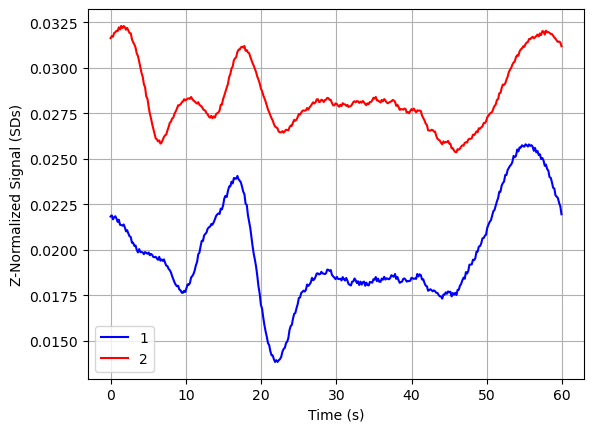

In [17]:
signal_1, signal_2, timestamps = recordSignals(amp1, amp2, 1200)
fig, ax = plt.subplots()

print("Signal 1 SD: {}".format(np.std(signal_1)))
print("Signal 2 SD: {}".format(np.std(signal_2)))

ax.plot(timestamps,signal_1, "b-")
ax.plot(timestamps,signal_2, "r-")
ax.grid()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Z-Normalized Signal (SDs)")
plt.legend(["1", "2"])
plt.show()

In [9]:
os.chdir("CSVs")
short=read_csv_to_array('SHIFT_DATA_control 100_12;51.csv')
os.chdir("..")

In [11]:
np.std(short)

1.2682217629421124

In [45]:
os.chdir("CSVs")
cover=read_csv_to_array('SHIFT_DATA_control 10_14;58.csv')
os.chdir("..")

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'CSVs'

In [47]:
os.chdir("..")

In [8]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets


# Replace 'USB::0x1234::5678::INSTR' with the correct resource string for your lock-in amplifier
lockin = amp1
lockin2 = amp2
# Function to get voltage measurement from the lock-in amplifier
def get_voltage():
    # query the voltage from your lock-in amplifiers
    return [float(lockin.query("OUTP? 1")), float(lockin2.query("OUTP? 1"))]


# Plot settings
plt.ion()
fig, ax = plt.subplots(figsize=(10,5))
line1, = ax.plot([], [], 'r-', label='Lock-in Amplifier 1')
line2, = ax.plot([], [], 'b-', label='Lock-in Amplifier 2')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Real-time Voltage Measurements')
xdata, ydata1, ydata2 = [], [], []

# Data acquisition loop
start_time = time.time()
try:
    while True:
        current_time = time.time() - start_time
        voltage = get_voltage()
        
        xdata.append(current_time)
        ydata1.append(voltage[0]) 
        ydata2.append(voltage[1])
        
        #line1.set_xdata(xdata)
        line2.set_xdata(xdata)
        #line1.set_ydata(ydata1)
        line2.set_ydata(ydata2)
        
        ax.relim()
        ax.autoscale_view()
        
        clear_output(wait=True)
        display(fig)
        
        plt.pause(0.1)  # Pause to control the update rate (e.g., 0.1 seconds)
except KeyboardInterrupt:
    print("Data acquisition stopped by user.")

# Turn off interactive plotting
plt.ioff()
plt.show()

Data acquisition stopped by user.


In [ ]:
np.std(ydata)